# WHFast tutorial

This tutorial is an introduction to the python interface of WHFast, a fast and unbiased symplectic Wisdom-Holman integrator. The method is described in Rein & Tamayo (2015).

This tutorial assumes that you have already installed REBOUND.

## First WHFast integration
You can enter all the commands below into a file and execute it all at once, or open an interactive shell).

First, we need to import the REBOUND module (make sure have have enabled the virtual environment if you used it to install REBOUND).

In [1]:
import rebound

Next, let's add some particles. We'll work in units in which $G=1$ (see below on how to set $G$ to another value). The first particle we add is the central object. We place it at rest at the origin and use the convention of setting the mass of the central object $M_*$ to 1:

In [2]:
rebound.add(m=1.)

Let's look at the particle we just added:

In [3]:
print(rebound.get_particles()[0])

<rebound.Particle object, m=1.0 x=0.0 y=0.0 z=0.0 vx=0.0 vy=0.0 vz=0.0>


The output tells us that the mass of the particle is 1 and all coordinates are zero. 

The next particle we're adding is a planet. We'll use Cartesian coordinates to initialize it. Any coordinate that we do not specify in the `rebound.add()` command is assumed to be 0. We place our planet on a circular orbit at $a=1$ and give it a mass of $10^{-3}$ times that of the central star.

In [4]:
rebound.add(m=1e-3, x=1., vy=1.)

Instead of initializing the particle with Cartesian coordinates, we can also use orbital elements. By default, REBOUND will use Jacobi coordinates, i.e. REBOUND assumes the orbital elements describe the particle's orbit around the centre of mass of all particles added previously. Our second planet will have a mass of $10^{-3}$, a semimajoraxis of $a=2$ and an eccentricity of $e=0.1$:

In [5]:
rebound.add(m=1e-3, a=2., e=0.1)

Now that we have added two more particles, let's have a quick look at what's "in REBOUND" by using

In [6]:
rebound.status()

---------------------------------
Rebound version:     	0.2.3
Build on:            	May 10 2015 17:42:12
Number of particles: 	3
Simulation time:     	0.000000
---------------------------------
<rebound.Particle object, m=1.0 x=0.0 y=0.0 z=0.0 vx=0.0 vy=0.0 vz=0.0>
<rebound.Particle object, m=0.001 x=1.0 y=0.0 z=0.0 vx=0.0 vy=1.0 vz=0.0>
<rebound.Particle object, m=0.001 x=1.800999001 y=0.0 z=0.0 vx=0.0 vy=0.783516306452 vz=0.0>
---------------------------------


Next, let's tell REBOUND which integrator (WHFast, of course!) and timestep we want to use. In our system of units, an orbit at $a=1$ has the orbital period of $T_{\rm orb} =2\pi \sqrt{\frac{GM}{a}}= 2\pi$. 
So a reasonable timestep to start with would be $dt=10^{-3}$.

In [7]:
rebound.set_integrator("whfast")
rebound.set_dt(1e-3)

`whfast` referrs to the 2nd order symplectic integrator WHFast described by Rein & Tamayo (2015). By default 11th order symplectic correctors are used. 

We are now ready to start the integration. Let's integrate for one orbit, i.e. until $t=2\pi$. Because we use a fixed timestep, rebound would have to change it to integrate exactly up to $2\pi$. Changing a timestep in a symplectic integrator is a bad idea, so we'll tell rebound to don't worry about the `exactFinishTime`.

In [8]:
rebound.integrate(6.28318530717959, exactFinishTime=0)   # 6.28318530717959 is 2*pi

Once again, let's look at what REBOUND's status is

In [9]:
rebound.status()

---------------------------------
Rebound version:     	0.2.3
Build on:            	May 10 2015 17:42:12
Number of particles: 	3
Simulation time:     	6.284000
---------------------------------
<rebound.Particle object, m=1.0 x=0.00332615486679 y=0.00967463591345 z=0.0 vx=0.000519465419816 vy=0.00122002692798 vz=0.0>
<rebound.Particle object, m=0.001 x=1.00326941817 y=0.0366289413116 z=0.0 vx=-0.0243959426078 vy=0.999978207226 vz=0.0>
<rebound.Particle object, m=0.001 x=-1.52842528396 y=1.49635161498 z=0.0 vx=-0.495069477208 vy=-0.436488828758 vz=0.0>
---------------------------------


As you can see the time has advanced to $t=2\pi$ and the positions and velocities of *all* particles have changed. If you want to post-process the particle data, you can access it in the following way:

In [10]:
particles = rebound.get_particles()
for i in range(rebound.get_N()):
    print(particles[i].x, particles[i].y, particles[i].vx, particles[i].vy)

(0.003326154866789341, 0.009674635913450578, 0.000519465419815916, 0.0012200269279836013)
(1.0032694181735986, 0.036628941311592965, -0.024395942607841364, 0.9999782072258975)
(-1.5284252839639376, 1.4963516149806406, -0.4950694772080744, -0.4364888287575557)


The `particles` object is a pointer to the particle array in memory. This means you can call `particles = rebound.get_particles()` before the integration and the contents of `particles` will be updated after the integration. If you add or remove particles, you'll need to call `get_particles()` again.

## Visualization with matplotlib
Instead of just printing boring numbers at the end of the simulation, let's visualize the orbit using matplotlib (you'll need to install numpy and matplotlib to run this example, see above).

We'll use the same particles as above. As the particles are already in memory, we don't need to add them again. Let us plot the position of the inner planet at 100 steps during its orbit. First, we'll import numpy and create an array of times for which we want to have an output (here, from $T_{\rm orb}$ to $2 T_{\rm orb}$ (we have already advanced the simulation time to $t=2\pi$).

In [11]:
import numpy as np
torb = 2.*np.pi
Noutputs = 100
times = np.linspace(torb, 2.*torb, Noutputs)
x = np.zeros(Noutputs)
y = np.zeros(Noutputs)

Next, we'll step through the simulation. Rebound will integrate up to `time`. Depending on the timestep, it might overshoot slightly. If you want to have the outputs at exactly the time you specify you can set the `exactTime=1` flag in the `integrate` function. However, note that changing the timestep in a symplectic integrator could have negative impacts on its properties.

In [12]:
for i,time in enumerate(times):
    rebound.integrate(time, exactFinishTime=0)
    x[i] = particles[1].x
    y[i] = particles[1].y

Let's plot the orbit using matplotlib.

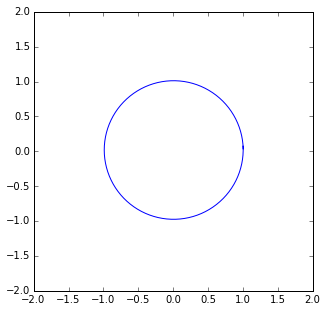

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5,5))
ax = plt.subplot(111)
ax.set_xlim([-2,2])
ax.set_ylim([-2,2])
plt.plot(x, y);

Hurray! It worked. The orbit looks like it should, it's an almost perfect circle. There are small perturbations though, induced by the outer planet. Let's integrate a bit longer to see them. 

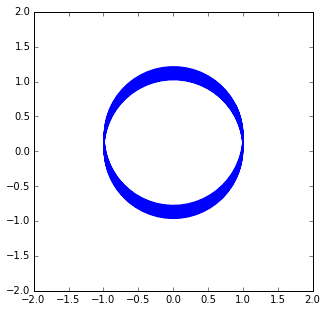

In [14]:
Noutputs = 1000
times = np.linspace(2.*torb, 20.*torb, Noutputs)
x = np.zeros(Noutputs)
y = np.zeros(Noutputs)
for i,time in enumerate(times):
    rebound.integrate(time, exactFinishTime=0)
    x[i] = particles[1].x
    y[i] = particles[1].y
    
fig = plt.figure(figsize=(5,5))
ax = plt.subplot(111)
ax.set_xlim([-2,2])
ax.set_ylim([-2,2])
plt.plot(x, y);

Oops! This doesn't look like what we expected to see (small perturbations to an almost circluar orbit). What you see here is the barycenter slowly drifting. Some integration packages require that the simulation be carried out in a particular frame, but WHFast provides extra flexibility by working in any inertial frame.  If you recall how we added the particles, the Sun was at the origin and at rest, and then we added the planets.  This means that the center of mass, or barycenter, will have a small velocity, which results in the observed drift.  There are multiple ways we can get the plot we want to.
1. We can calculate only relative positions.
2. We can add the particles in the barycentric frame.
3. We can let REBOUND transform the particle coordinates to the bayrcentric frame for us.

Let's use the third option (next time you run a simulation, you probably want to do that at the beginning).

In [15]:
rebound.move_to_center_of_momentum()

So let's try this again. Let's integrate for a bit longer this time.

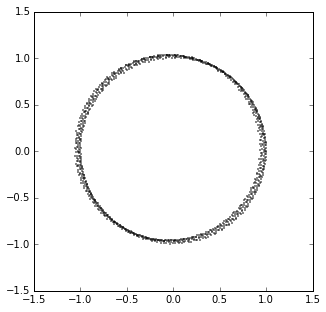

In [16]:
times = np.linspace(20.*torb, 1000.*torb, Noutputs)
for i,time in enumerate(times):
    rebound.integrate(time, exactFinishTime=0)
    x[i] = particles[1].x
    y[i] = particles[1].y
    
fig = plt.figure(figsize=(5,5))
ax = plt.subplot(111)
ax.set_xlim([-1.5,1.5])
ax.set_ylim([-1.5,1.5])
plt.scatter(x, y, marker='.', color='k', s=1.2);

That looks much more  like it. Let us finally plot the orbital elements as a function of time.

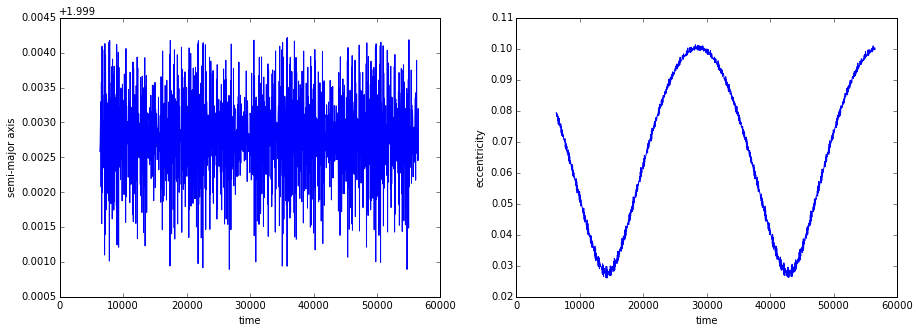

In [17]:
times = np.linspace(1000.*torb, 9000.*torb, Noutputs)
a = np.zeros(Noutputs)
e = np.zeros(Noutputs)
for i,time in enumerate(times):
    rebound.integrate(time, exactFinishTime=0)
    orbits = rebound.get_orbits()
    a[i] = orbits[1].a
    e[i] = orbits[1].e
    
fig = plt.figure(figsize=(15,5))

ax = plt.subplot(121)
ax.set_xlabel("time")
ax.set_ylabel("semi-major axis")
plt.plot(times, a);

ax = plt.subplot(122)
ax.set_xlabel("time")
ax.set_ylabel("eccentricity")
plt.plot(times, e);

The semimajor axis seems to almost stay constant, whereas the eccentricity undergoes an oscillation. Thus, one might conclude the planets interact only secularly, i.e. there are no large resonant terms.

## Save/load particles from file, reset rebound

You can very easily save all particles to a binary file. The binary file will include the mass, positions and velocities of all particles, as well as the current simulation time (but nothing else!):

In [18]:
rebound.save("checkpoint.bin")

The binary files are small in size and store every floating point number exactly, so you don't have to worry about efficiency or loosing precision. You can make lots of checkpoints.

Now, suppose we want to reset rebound. For example to run a different simulation. You can simply call

In [19]:
rebound.reset()

This will clear all particles ($N=0$ afterwards), set the time to zero, reset the integrator settings. Basically, you'll have to start from scratch. However, since we saved a binary file earlier we can use that to load the particles back into memory:

In [20]:
rebound.load("checkpoint.bin")
rebound.status()

---------------------------------
Rebound version:     	0.2.3
Build on:            	May 10 2015 17:42:12
Number of particles: 	3
Simulation time:     	56548.668038
---------------------------------
<rebound.Particle object, m=1.0 x=0.00114717628038 y=0.000445309619738 z=0.0 vx=-0.000668987677577 vy=0.00012064164774 vz=0.0>
<rebound.Particle object, m=0.001 x=0.640711392651 y=-0.756112486567 z=0.0 vx=0.772804259687 vy=0.647864437961 vz=0.0>
<rebound.Particle object, m=0.001 x=-1.78788767288 y=0.310802866826 z=0.0 vx=-0.103816582109 vy=-0.768506085701 vz=0.0>
---------------------------------


Just as a test, let's change the particles' velocity, by multiplying it with minus one. Thus, all particles will be moving backwards!

In [21]:
p = rebound.get_particles()
for i in range(0,rebound.get_N()):
    p[i].vx *= -1.
    p[i].vy *= -1.
    p[i].vz *= -1.

Then, let's setup the integrator again (remember, the `reset()` call reset everything):

In [22]:
rebound.set_integrator("whfast")
rebound.set_dt(1e-3)

If we now set the time from $t$ to $-t$ and integrate back to 0, then the particles should roughly be back where they started from. Let's also move back to the heliocentric frame.

In [23]:
rebound.set_t(-rebound.get_t())
rebound.integrate(0.)
for i in range(rebound.get_N()-1,-1,-1):
    p[i].x -= p[0].x
    p[i].y -= p[0].y
    p[i].z -= p[0].z
    p[i].vx -= p[0].vx
    p[i].vy -= p[0].vy
    p[i].vz -= p[0].vz

rebound.status()

---------------------------------
Rebound version:     	0.2.3
Build on:            	May 10 2015 17:42:12
Number of particles: 	3
Simulation time:     	0.000000
---------------------------------
<rebound.Particle object, m=1.0 x=0.0 y=0.0 z=0.0 vx=0.0 vy=0.0 vz=0.0>
<rebound.Particle object, m=0.001 x=0.999999999999 y=-6.2969300657e-08 z=0.0 vx=-6.30158152872e-08 vy=-1.0 vz=0.0>
<rebound.Particle object, m=0.001 x=1.800999001 y=2.10951342898e-08 z=0.0 vx=8.18096390903e-09 vy=-0.783516306451 vz=0.0>
---------------------------------


It worked. If you compare this output to the first output we got just after we added the particles, you'll see that the positions are almost exactly identical. There is a small difference due to numerical round-off erros (see Rein & Tamayo, 2015). Nevertheless, this proves that WHFast is time-reversible.